In [1]:
from astropy.io import fits
from astropy import units, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner 
from voigt_fit_lib import *
import os
import pickle
from scipy import interpolate

Load in the files

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/'

First, the FUV files

In [3]:
spec_fits_fuv = fits.open(rootdir + 'FUV/PG1522+101_FUV_wavecal_new.fits')
lsf_fits_fuv = fits.open(rootdir + 'FUV/PG1522_COS_FUV_wavcal2022_lsf_ZQ.fits')

Then, the NUV files

In [4]:
spec_fits_nuv = fits.open(rootdir + 'G185M/PG1522+101_NUV_wavecal_new.fits')
lsf_fits_nuv = fits.open(rootdir + 'G185M/PG1522_COS_NUV_wavcal2022_lsf.fits')

Then, the STIS files

In [5]:
spec_fits_stis = fits.open(rootdir + 'STIS/PG1522+101_E230M_new.fits')
lsf_fits_stis = fits.open(rootdir + 'STIS/PG1522_STIS_NUV_wavcal2022_lsf.fits')

Then, the HIRES files

In [6]:
spec_fits_hires = fits.open(rootdir + 'HIRES/PG1522+101_HIRES.fits')
lsf_fits_hires = fits.open(rootdir + 'HIRES/PG1522_HIRES_wavcal2023_lsf.fits')

Compile a list of the spectra, continuum nodes, and IDs for all detectors

In [7]:
spec_fits_list = [spec_fits_fuv, spec_fits_nuv, spec_fits_stis, spec_fits_hires]
lsf_fits_list = [lsf_fits_fuv, lsf_fits_nuv, lsf_fits_stis, lsf_fits_hires]

Systemic redshift

In [8]:
z_sys = 0.67545705

# CII 1036

In [9]:
cii_1036_fuv = ion_transition('CII', 1036, 'C', z_sys, 'FUV')

In [10]:
cii_1036_fuv.grab_ion_transition_info()

In [11]:
cii_1036_fuv.grab_ion_transition_spec(spec_fits_list)

In [12]:
cii_1036_fuv.cont_norm_flux(v_abs_range=[-100,100], degree=1)

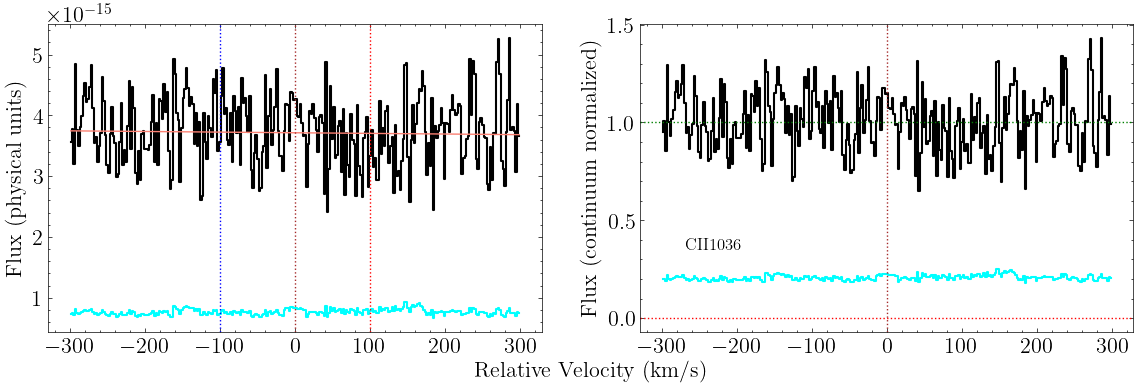

In [13]:
fig, axes = cii_1036_fuv.plot_ion_transition_spec_cont()

In [14]:
cii_1036_fuv.grab_ion_transition_lsf(lsf_fits_list)

Re-define variables

In [15]:
v = cii_1036_fuv.v
flux_obs = cii_1036_fuv.flux_norm
err_std = cii_1036_fuv.err_norm

In [16]:
b = 30

Define function for constructing a Voigt profile

In [17]:
def vp(v, logN, lsf_convolve=True):
    
    model = comp_model_spec_gen(v, np.array([[logN, b, 0]]), 
                                cii_1036_fuv.wav0_rest, cii_1036_fuv.f, cii_1036_fuv.gamma, cii_1036_fuv.A,
                                lsf_convolve,
                                cii_1036_fuv.lsf, cii_1036_fuv.v_lsf)[1]
    
    return model

Construct a mock profile to test convolution and measure the new FWHM

In [18]:
# Unconvolved and convolved profiles
mock_unconv = vp(v, 13, False)
mock_conv = vp(v, 13, True)

# Flux levels for FWHM in each profile
flux_fwhm_unconv = 1-0.5*(1-np.min(mock_unconv))
flux_fwhm_conv = 1-0.5*(1-np.min(mock_conv))

# Corresponding FWHM calculation
fwhm_unconv = 2*v[v>0][np.argmin(np.abs(mock_unconv[v>0]-flux_fwhm_unconv))]
fwhm_conv = 2*v[v>0][np.argmin(np.abs(mock_conv[v>0]-flux_fwhm_conv))]

In [19]:
np.sum(1-mock_conv), np.sum(1-mock_unconv)

(1.5038307567992766, 1.5043361326960927)

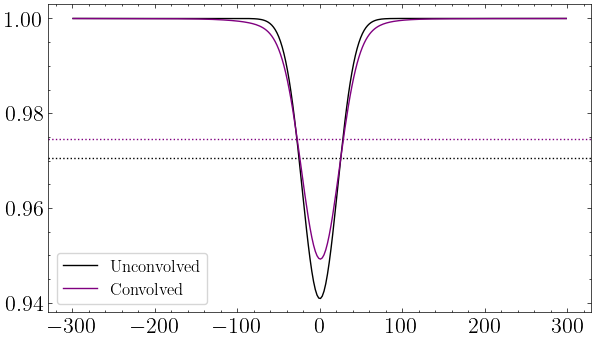

In [20]:
fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(v, mock_unconv, label='Unconvolved', color='black')
ax.axhline(flux_fwhm_unconv, color='black', linestyle=':')
ax.plot(v, mock_conv, label='Convolved', color='purple')
ax.axhline(flux_fwhm_conv, color='purple', linestyle=':')
ax.legend()

In [21]:
v_c = 40

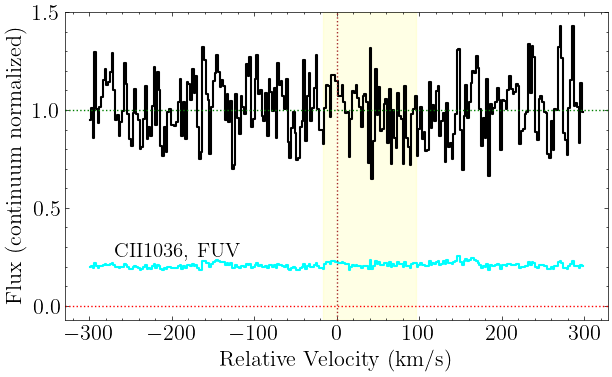

In [22]:
fig, ax = cii_1036_fuv.plot_ion_transition_spec()
ax.axvspan(xmin=v_c-fwhm_conv, xmax=v_c+fwhm_conv, color='yellow', alpha=.1)

In [23]:
from scipy.stats import chi2, kstest, ks_2samp

Run the Monte Carlo experiment - generate mock noisy signals

In [24]:
idx = (v>-100)&(v<100)

In [25]:
N_trials = 1500

In [26]:
# For each logN for each trial, get Gaussian noise
noise_grid = np.zeros((N_trials, len(v)))
chi_sq0_def = np.zeros(N_trials)

# For each spectral pixel
for k in range(len(v)):
    # Generate noise for all logN, for each trial
    noise_samples = np.random.normal(loc=0, scale=err_std[k], size=N_trials)
    # Save the reshaped noise in the larger grid
    noise_grid[:,k] = noise_samples
    
for i in range(N_trials):
    chi_sq0_def[i] = np.sum(((noise_grid[i,:]/err_std)[idx])**2)

Text(0, 0.5, 'PDF')

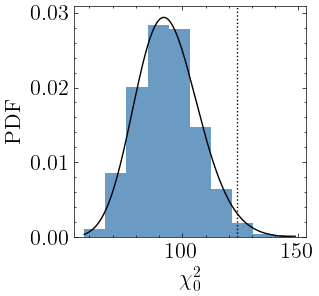

In [27]:
fig, ax = plt.subplots(1, figsize=(3,3))

xrange = np.arange(np.min(chi_sq0_def), np.max(chi_sq0_def), 0.1)
chi2_pdf = chi2.pdf(xrange, len(v[idx]))

ax.hist(chi_sq0_def, color='steelblue', alpha=.8, density=True)
ax.axvline(chi2.ppf(cdf_2sig, len(v[idx])), linestyle=':')

ax.plot(xrange,chi2_pdf)

ax.set_xlabel(r'$\chi^2_0$')
ax.set_ylabel(r'PDF')

In [28]:
kstest(chi_sq0_def, chi2.cdf, args=((len(v[idx]),)))

KstestResult(statistic=0.029989697821644734, pvalue=0.13193825156044814)

Generate mock spectra

In [29]:
# Generate clean models
logN_grid = np.linspace(12.5, 14.0, 100) 
#logN_grid = np.log10(np.linspace(10**12.0, 10**13.5, 200))

model_grid = np.zeros((len(logN_grid), len(v)))

for j in range(len(logN_grid)):
    model_grid[j,:] = vp(v, logN_grid[j])

In [30]:
# Generate noisy signals
signal_grid = np.zeros((N_trials, len(logN_grid), len(v)))
chi_sq0_grid = np.zeros((N_trials, len(logN_grid)))

for i in range(N_trials):
    for j in range(len(logN_grid)):
        # Add trial noise and clean model 

        #signal_grid[i,j,:] = (1+noise_grid[i,:])*model_grid[j,:]
        signal_grid[i,j,:] = noise_grid[i,:]+model_grid[j,:]
        chi_sq0_grid[i,j] = np.sum((((signal_grid[i,j,:]-1)/err_std)[idx])**2)

Get average $p$ values for each input $\log N$ and convert into a CDF value

In [31]:
from scipy.interpolate import interp1d

In [32]:
chi_sq0_cdf = interp1d(np.sort(chi_sq0_def),
                      np.cumsum(np.sort(chi_sq0_def))/np.sum(chi_sq0_def),
                      fill_value='extrapolate')

In [33]:
chi_sq0_cdf_grid = chi_sq0_cdf(chi_sq0_grid)

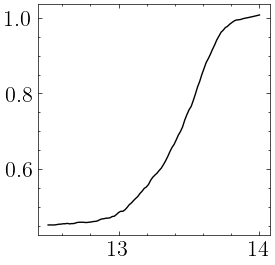

In [34]:
fig, ax = plt.subplots(1,figsize=(3,3))

ax.plot(logN_grid, np.median(chi_sq0_cdf_grid, axis=0))

In [35]:
np.interp(0.5, np.median(chi_sq0_cdf_grid, axis=0), logN_grid)

13.063640404775942

Perform a KS test

In [36]:
ksp_grid = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    d, p = kstest(chi_sq0_grid[:,j], chi_sq0_def)
    ksp_grid[j] = p

In [54]:
chi_sq0_2sig = chi_sq0_grid[:,np.argmin(np.abs(logN_grid-13.0))]
chi_sq0_3sig = chi_sq0_grid[:,np.argmin(np.abs(logN_grid-13.1))]

Text(0, 0.5, 'PDF')

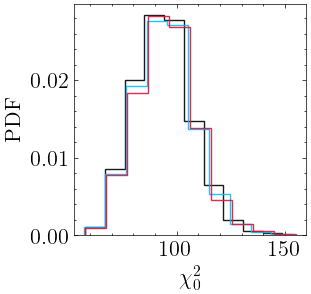

In [55]:
fig, ax = plt.subplots(1, figsize=(3,3))

ax.hist(chi_sq0_def, alpha=.9, histtype='step', density=True)
ax.hist(chi_sq0_2sig, alpha=.9, histtype='step', density=True)
ax.hist(chi_sq0_3sig, alpha=.9, histtype='step', density=True)

ax.set_xlabel(r'$\chi^2_0$')
ax.set_ylabel('PDF')

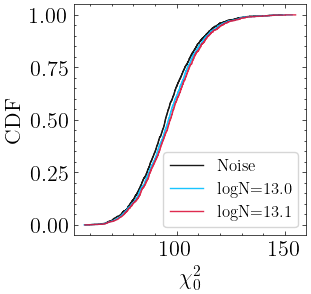

In [57]:
fig, ax = plt.subplots(1, figsize=(3,3))

ax.step(np.sort(chi_sq0_def), 
        np.cumsum(np.sort(chi_sq0_def))/np.sum(np.sort(chi_sq0_def)), alpha=.9, where='mid', label='Noise')

ax.step(np.sort(chi_sq0_2sig), 
        np.cumsum(np.sort(chi_sq0_2sig))/np.sum(np.sort(chi_sq0_2sig)), alpha=.9, where='mid', label='logN=13.0')

ax.step(np.sort(chi_sq0_3sig), 
        np.cumsum(np.sort(chi_sq0_3sig))/np.sum(np.sort(chi_sq0_3sig)), alpha=.9, where='mid', label='logN=13.1')

ax.set_xlabel(r'$\chi^2_0$')
ax.set_ylabel('CDF')

ax.legend()

Text(0.5, 0, '$\\log N$')

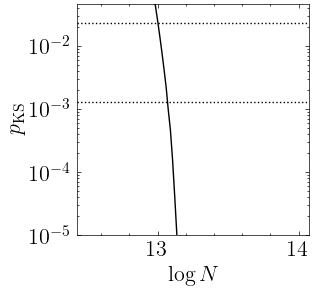

In [58]:
fig, ax = plt.subplots(1, figsize=(3,3))

ax.plot(logN_grid, ksp_grid)

ax.axhline(1-cdf_2sig, linestyle=':')
ax.axhline(1-cdf_3sig, linestyle=':')

ax.set_ylim(1e-5, 2*(1-cdf_2sig))

ax.set_yscale('log')
ax.set_ylabel(r'$p_\mathrm{KS}$')
ax.set_xlabel(r'$\log N$')

In [59]:
(interp1d(ksp_grid, logN_grid)([1-cdf_2sig])[0], 
interp1d(ksp_grid, logN_grid)([1-cdf_3sig])[0])

(13.003358904755899, 13.071711463561954)

Also do a threshold rejection test

In [60]:
chi_sq0_thresh_2sig = np.percentile(chi_sq0_def, 100*cdf_2sig)
chi_sq0_thresh_3sig = np.percentile(chi_sq0_def, 100*cdf_3sig)

In [77]:
chi_sq0_thresh_2sig, chi_sq0_thresh_3sig

(122.58943993939427, 143.44902579884493)

In [61]:
p_det_2sig = np.zeros(len(logN_grid))
p_det_3sig = np.zeros(len(logN_grid))

for j in range(len(logN_grid)):
    p_det_2sig[j] = np.sum(chi_sq0_grid[:,j]>chi_sq0_thresh_2sig)
    p_det_3sig[j] = np.sum(chi_sq0_grid[:,j]>chi_sq0_thresh_3sig)
    
p_det_2sig /= N_trials
p_det_3sig /= N_trials

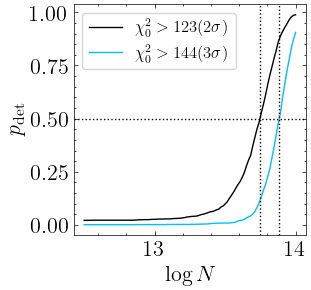

In [85]:
fig, ax = plt.subplots(1, figsize=(3,3))

ax.plot(logN_grid, p_det_2sig, label=r'$\chi^2_0 > 123 (2 \sigma)$')
ax.plot(logN_grid, p_det_3sig, label=r'$\chi^2_0 > 144 (3 \sigma)$')

ax.axvline(np.interp(0.5, p_det_2sig, logN_grid), linestyle=':')
ax.axvline(np.interp(0.5, p_det_3sig, logN_grid), linestyle=':')

ax.set_xlabel(r'$\log N$')
ax.set_ylabel(r'$p_\mathrm{det}$')

ax.axhline(0.5, linestyle=':')
ax.legend()
#ax.axhline(1-cdf_3sig, linestyle=':')
#
#ax.set_ylim(1e-5, 2*(1-cdf_1sig))
#ax.set_yscale('log')

In [82]:
np.interp(0.5, p_det_2sig, logN_grid)

13.747319347319348

In [83]:
np.interp(0.5, p_det_3sig, logN_grid)

13.883769198837692

Focus on a particular input column density

In [71]:
logN_plot = 13.1
logN_idx = np.argmin(np.abs(logN_grid-logN_plot))

In [72]:
logN_grid[logN_idx]

13.106060606060606

Text(0, 0.5, 'PDF')

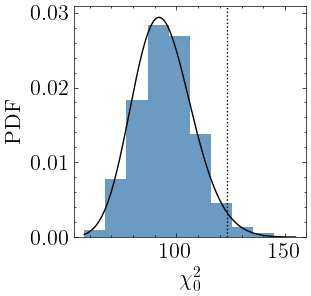

In [73]:
fig, ax = plt.subplots(1, figsize=(3,3))

xrange = np.arange(np.min(chi_sq0_grid[:,logN_idx]), np.max(chi_sq0_grid[:,logN_idx]), 0.1)
chi2_pdf = chi2.pdf(xrange, len(v[idx]))

ax.hist(chi_sq0_grid[:,logN_idx], color='steelblue', alpha=.8, density=True)
ax.axvline(chi2.ppf(cdf_2sig, len(v[idx])), linestyle=':')

ax.plot(xrange,chi2_pdf)

ax.set_xlabel(r'$\chi^2_0$')
ax.set_ylabel(r'PDF')

In [74]:
trials_indices = np.random.randint(low=0, high=N_trials, size=4)

Text(0, 0.5, 'Flux (continuum normalized)')

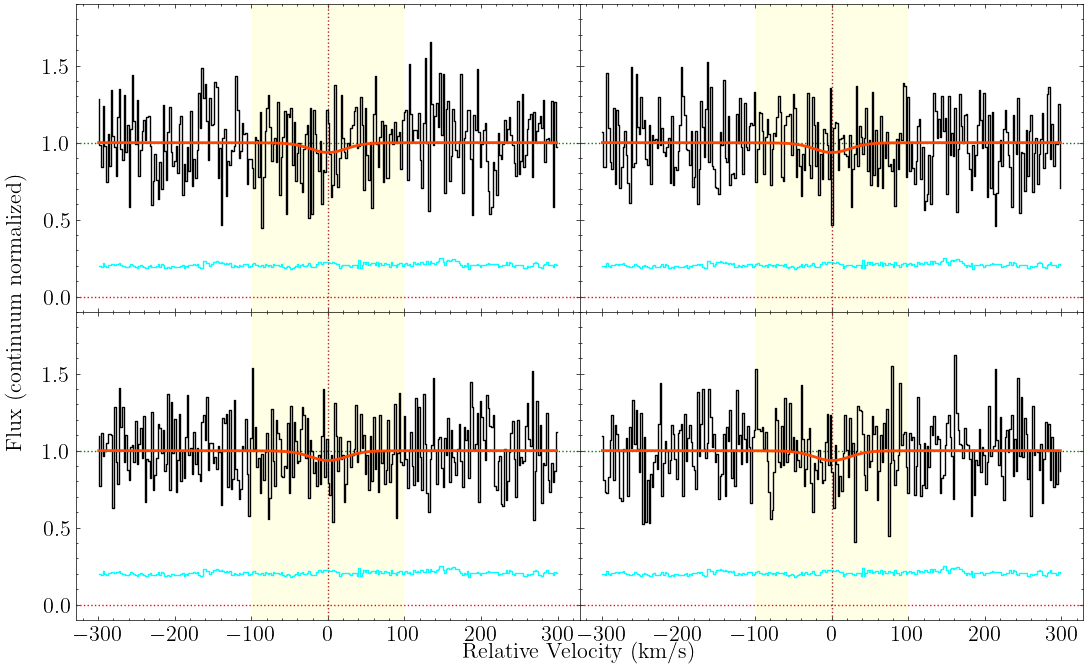

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

axes[0,0].set_ylim(-0.1, 1.9)

for i in range(len(trials_indices)):
    
    ax = axes[i//2, i%2]
    ax.axvline(0, linestyle=':', color='brown')
    ax.axhline(0, linestyle=':', color='red')
    ax.axhline(1, linestyle=':', color='green')
    trial_idx = trials_indices[i]
    ax.step(v, signal_grid[trial_idx, logN_idx, :], where='mid')
    ax.plot(v, model_grid[logN_idx, :], color='orangered', lw=2)
    #ax.plot(v, vp(v, logN_best_grid[trial_idx, logN_idx]), color='lavender', lw=2)


    ax.step(v, err_std, where='mid', color='cyan')
    ax.axvspan(xmin=v[idx][0], xmax=v[idx][-1], color='yellow', alpha=.1)
    #ax.text(x=-280, y=1.7, s=r'$\sigma_\mathrm{logN} = $'+' {:.2f}'.format(sig_logN_grid[trial_idx, logN_idx]))
    
plt.subplots_adjust(wspace=0, hspace=0)   

ax_label = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
ax_label.set_xticks([])
ax_label.set_yticks([])
ax_label.set_xlabel('Relative Velocity (km/s)', labelpad=15) # Use argument `labelpad` to move label downwards.
ax_label.set_ylabel('Flux (continuum normalized)', labelpad=35)

Compute corresponding upper limits using equivalent width

In [49]:
v_abs = v[idx]
err_abs = err_std[idx][:-1] # Excluding the last element is important to mimic integration

In [50]:
delta_lambda = np.mean(((v_abs[1:]-v_abs[:-1])*cii_1036_fuv.wav0_rest/3e+5)*1e+3) # in mA
EW_1sig = np.sqrt(np.sum((err_abs[:-1]*delta_lambda)**2))

In [51]:
N_1sig = (EW_1sig*1e-3/cii_1036_fuv.wav0_rest)*(3e+8/(cii_1036_fuv.wav0_rest*1e-10))*(2.654e-2*cii_1036_fuv.f)**-1

In [52]:
logN_1sig_EW = np.round(np.log10(N_1sig),1)
logN_2sig_EW = np.round(np.log10(2*N_1sig),1)
logN_3sig_EW = np.round(np.log10(3*N_1sig),1)

In [53]:
logN_1sig_EW, logN_2sig_EW, logN_3sig_EW

(13.1, 13.4, 13.6)